In [1]:
import geopandas as gpd
import xarray as xr

In [2]:
import rioxarray as rxr
import contextily as cx
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns


## Import Hurricanes Dataset

We will import the hurricanes dataset and look at the columns. Next we will pare it down to only to years post 1990 and onwards

In [5]:
hurricanes = gpd.read_file("C:\\Users\\Kevin\\Downloads\\IBTrACS.NA.list.v04r01.points\\IBTrACS.NA.list.v04r01.points.shp")


In [6]:
hurricanes.tail()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,USA_SEA_SW,USA_SEA_NW,STORM_SPD,STORM_DR,year,month,day,hour,min,geometry
126833,2024319N16282,2024,87,NA,CS,SARA,2024-11-17 14:00:00,TS,17.0,-88.3,...,NaN,30.0,13.0,300.0,2024,11,17,14,0,POINT (-88.3 17)
126834,2024319N16282,2024,87,NA,NA,SARA,2024-11-17 15:00:00,TS,17.1,-88.5,...,NaN,30.0,13.0,300.0,2024,11,17,15,0,POINT (-88.5 17.1)
126835,2024319N16282,2024,87,NA,NA,SARA,2024-11-17 18:00:00,TS,17.4,-89.1,...,NaN,30.0,12.0,295.0,2024,11,17,18,0,POINT (-89.1 17.4)
126836,2024319N16282,2024,87,NA,NA,SARA,2024-11-17 21:00:00,TS,17.7,-89.7,...,NaN,NaN,12.0,295.0,2024,11,17,21,0,POINT (-89.7 17.7)
126837,2024319N16282,2024,87,NA,NA,SARA,2024-11-18 00:00:00,TS,17.9,-90.2,...,NaN,NaN,11.0,295.0,2024,11,18,0,0,POINT (-90.2 17.9)


In [7]:
for col in hurricanes:
    print(col)

SID
SEASON
NUMBER
BASIN
SUBBASIN
NAME
ISO_TIME
NATURE
LAT
LON
WMO_WIND
WMO_PRES
WMO_AGENCY
TRACK_TYPE
DIST2LAND
LANDFALL
IFLAG
USA_AGENCY
USA_ATCFID
USA_LAT
USA_LON
USA_RECORD
USA_STATUS
USA_WIND
USA_PRES
USA_SSHS
USA_R34_NE
USA_R34_SE
USA_R34_SW
USA_R34_NW
USA_R50_NE
USA_R50_SE
USA_R50_SW
USA_R50_NW
USA_R64_NE
USA_R64_SE
USA_R64_SW
USA_R64_NW
USA_POCI
USA_ROCI
USA_RMW
USA_EYE
TOK_LAT
TOK_LON
TOK_GRADE
TOK_WIND
TOK_PRES
TOK_R50_DR
TOK_R50_L
TOK_R50_S
TOK_R30_DR
TOK_R30_L
TOK_R30_S
TOK_LAND
CMA_LAT
CMA_LON
CMA_CAT
CMA_WIND
CMA_PRES
HKO_LAT
HKO_LON
HKO_CAT
HKO_WIND
HKO_PRES
KMA_LAT
KMA_LON
KMA_CAT
KMA_WIND
KMA_PRES
KMA_R50_DR
KMA_R50_L
KMA_R50_S
KMA_R30_DR
KMA_R30_L
KMA_R30_S
NEW_LAT
NEW_LON
NEW_GRADE
NEW_WIND
NEW_PRES
NEW_CI
NEW_DP
NEW_POCI
REU_LAT
REU_LON
REU_TYPE
REU_WIND
REU_PRES
REU_TNUM
REU_CI
REU_RMW
REU_R34_NE
REU_R34_SE
REU_R34_SW
REU_R34_NW
REU_R50_NE
REU_R50_SE
REU_R50_SW
REU_R50_NW
REU_R64_NE
REU_R64_SE
REU_R64_SW
REU_R64_NW
BOM_LAT
BOM_LON
BOM_TYPE
BOM_WIND
BOM_PRES
BOM_TNUM

In [8]:
#change the date time format to pandas datetime format
hurricanes['ISO_TIME'] = pd.to_datetime(hurricanes['ISO_TIME'], errors='coerce')

In [9]:
#filter for only tropical strength hurricanes theses are for winds that are over 34 knots 
hurricanes = hurricanes[hurricanes['USA_WIND']>= 34]

# Filter years 1990<
hurricanes = hurricanes[hurricanes['year'] >= 1990]

In [10]:
#sort by time and when it was observed
hurricanes_sorted = hurricanes.sort_values('ISO_TIME')
genesis_df = hurricanes_sorted.groupby('SID').first().reset_index()

In [11]:
#Storm count per year
storm_counts = genesis_df.groupby('year')['SID'].nunique().reset_index(name='storm_count')

# Verify the range and print the first few rows of data
print(storm_counts['year'].min(), storm_counts['year'].max())
print(storm_counts.head())

1990 2024
   year  storm_count
0  1990           14
1  1991            8
2  1992            7
3  1993            9
4  1994            7


## Accumulated Cyclone Energy

One key factor in hurricanes is called the ACE, the Accumulated Cyclone Energy. There is no column for this in our dataset but it can be caluclated. The formula for this is as follows: "summing the squares of the estimated maximum sustained velocity of tropical cyclones when wind speeds are at least tropical storm strength (≥ 34 kn; 63 km/h; 39 mph)[4] at recorded six-hour intervals. The sums are usually divided by 10,000 to make them more manageable" (Wikipedia, 2025)

In [12]:
# Make a copy of the hurricanes dataset first
ace_df = hurricanes[hurricanes['USA_WIND'] >= 34].copy()
#Get the V^2
ace_df['V_squared'] = ace_df['USA_WIND'] ** 2
#sum across all indexes by year
ace_per_year = ace_df.groupby('year')['V_squared'].sum().reset_index()

#Divide by 10,000
ace_per_year['ACE'] = ace_per_year['V_squared'] / 10000


In [13]:
# Merge this dataset with our current working storm_counts datast
storm_metrics = storm_counts.merge(ace_per_year, on='year', how='left')
storm_metrics = storm_metrics.drop(columns= 'V_squared')

# Preview
storm_metrics.head(35)

,year,storm_count,ACE
0,1990,14,196.3938
1,1991,8,85.1744
2,1992,7,166.7311
3,1993,9,86.4490
4,1994,7,63.7578
5,1995,19,502.6689
6,1996,13,368.4375
7,1997,8,91.6233
8,1998,14,408.3649
9,1999,12,366.0011


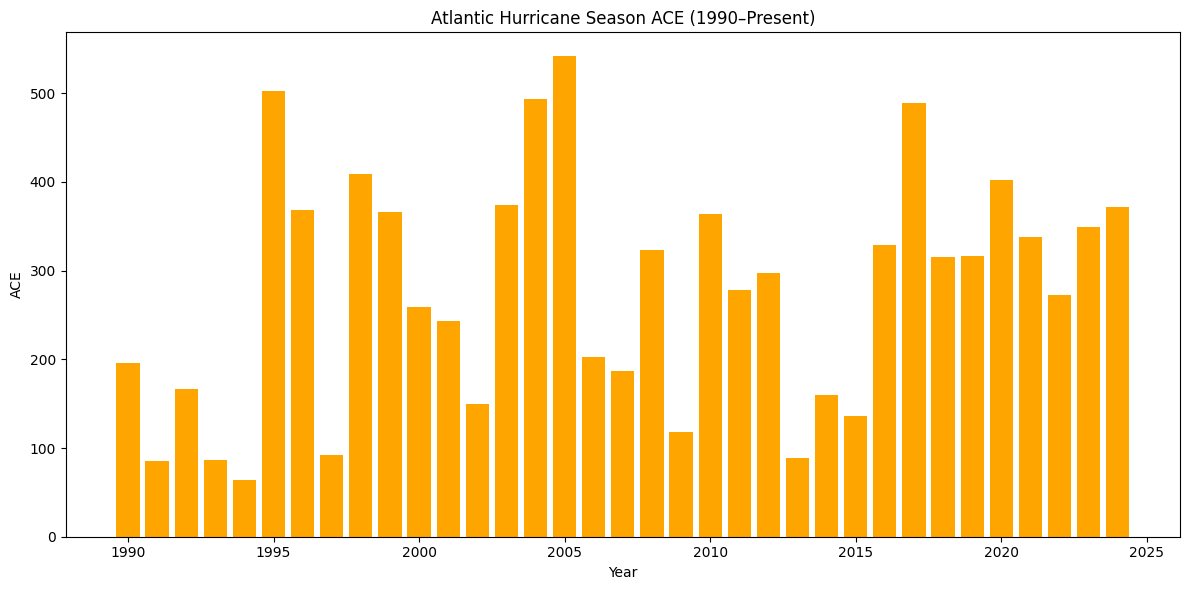

In [14]:
plt.figure(figsize=(12,6))
plt.bar(storm_metrics['year'], storm_metrics['ACE'], color='orange')
plt.title('Atlantic Hurricane Season ACE (1990–Present)')
plt.xlabel('Year')
plt.ylabel('ACE')
plt.tight_layout()
plt.show()

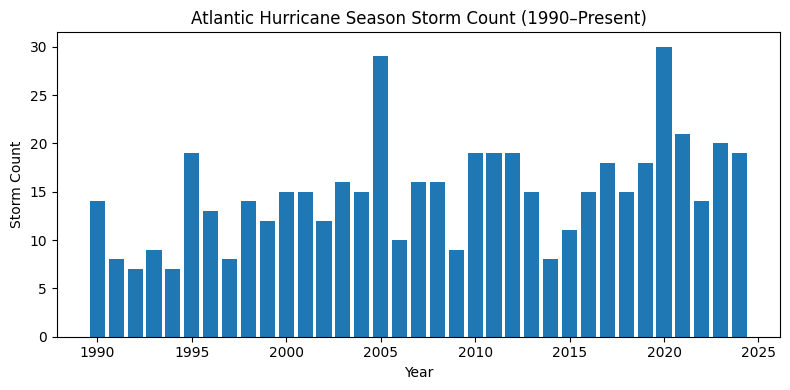

In [15]:
plt.figure(figsize=(8,4))
plt.bar(storm_metrics['year'], storm_metrics['storm_count'])
plt.title('Atlantic Hurricane Season Storm Count (1990–Present)')

plt.xlabel('Year')
plt.ylabel('Storm Count')
plt.tight_layout()
plt.show()

## Load the Sea Surface Temperature dataset

Next we will load the sea surface temperature dataset and start the data cleaning/munging

In [16]:
#Load the sea surface temp dataset
sst = xr.open_dataset('C:\\Users\\Kevin\\Downloads\\sst.mnmean.nc')
# This dataset is more granular will get a better looking chart when plotted. I will use the lower density chart for my regression data
sst_refined = xr.open_dataset('C:\\Users\\Kevin\\Downloads\\sst.mon.mean.nc')

## Regions

Now we will look to splice this into our main regions we are focused on here. This will be the Atlantic, Gulf, and Caribbean regions

In the Atlantic Ocean there is the Main Development Region (MDR) taht is bounded 10-20 N and 20-60 W where 80% of all major hurricanes devlop from Afriance Easterly Waves

In [17]:
# Splice regions 
#Main Development Region (Atlantic)
sst_mdr = sst.sel(lat=slice(20, 10), lon=slice(260, 340))  
# Caribbean
sst_caribbean = sst.sel(lat=slice(25, 10), lon=slice(265, 295))

#Gulf
sst_gulf = sst.sel(lat=slice(31, 18), lon=slice(260, 275))  

## Change CRS to EPSG 4326 

We do this because its a global standard for geographic coordinate systems. We are not calculating area here so not worried about equal areas

In [20]:
sst_mdr.rio.write_crs("EPSG:4326")
sst_caribbean.rio.write_crs("EPSG:4326")
sst_gulf.rio.write_crs("EPSG:4326")

<xarray.Dataset> Size: 510kB
Dimensions:      (lat: 7, lon: 8, time: 2057, nbnds: 2)
Coordinates:
  * lat          (lat) float32 28B 30.0 28.0 26.0 24.0 22.0 20.0 18.0
  * lon          (lon) float32 32B 260.0 262.0 264.0 266.0 ... 270.0 272.0 274.0
  * time         (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2025-05-01
    spatial_ref  int64 8B 0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds    (time, nbnds) float64 33kB ...
    sst          (time, lat, lon) float32 461kB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2025-06-03

In [21]:
filename = 'C:\\Users\\Kevin\\Downloads\\wc2.1_10m_elev\\wc2.1_10m_elev.tif'
raster = rasterio.open(filename)

<Axes: title={'center': 'World Map'}>

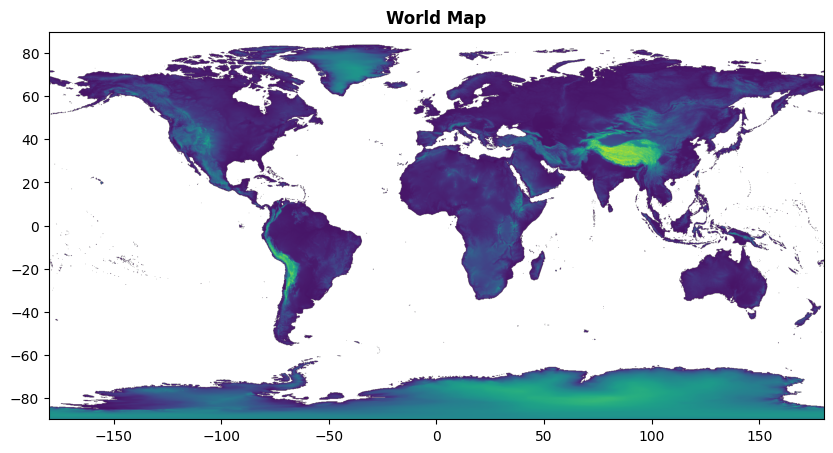

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
show(raster, ax=ax, title='World Map')

In [23]:
sst_sample = sst['sst'].sel(time='2005-04-01')

In [24]:
#Make a subset of all 3 regions Gulf Atl and Carib
sst_subset = sst_sample.sel(lat=slice(0, 40), lon=slice(-100, -10))

# EDA Plot

Since it looks like 2005 had the most hurricanes and intensity lets look at the sea surface temps for that year preceding Hurricane season (Hurricane season starts in June but most Hurricanes happen in August-October)

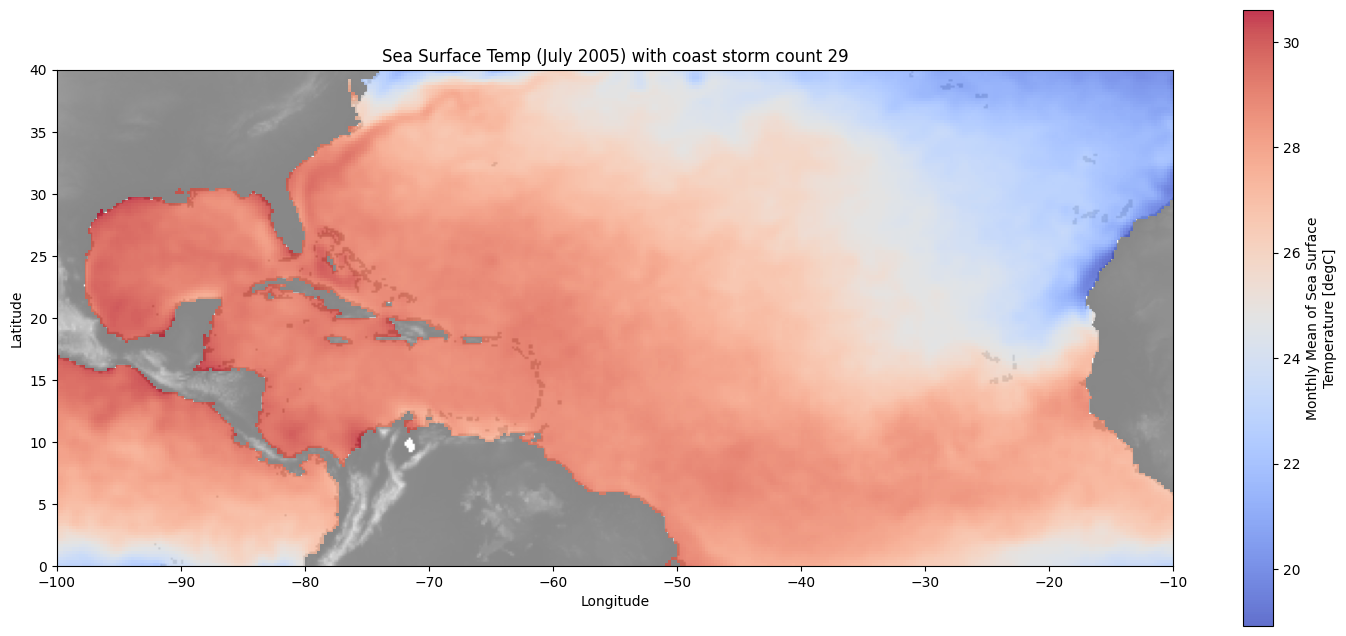

In [25]:
# Load raster
raster = rasterio.open('C:\\Users\\Kevin\\Downloads\\wc2.1_10m_elev\\wc2.1_10m_elev.tif')

# Load SST dataset
sst_ds = xr.open_dataset("C:\\Users\\Kevin\\Downloads\\sst.mon.mean.nc")
# Get the coordinates to the same as the raster
sst_ds = sst_ds.assign_coords(lon=(((sst_ds.lon + 180) % 360) - 180)).sortby('lon')
sst_sample = sst_ds['sst'].sel(time='2005-07-01')
sst_subset = sst_sample.sel(lat=slice(0,40), lon=slice(-100,-10))

# Plot both
fig, ax = plt.subplots(figsize=(18, 8))

#plot raster
show(raster, ax=ax, cmap='Greys_r', alpha=0.5)

# plot SST
sst_plot = sst_subset.plot(ax=ax, cmap='coolwarm', alpha=0.8, add_colorbar=True)

ax.set_title("Sea Surface Temp (July 2005) with coast storm count 29")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


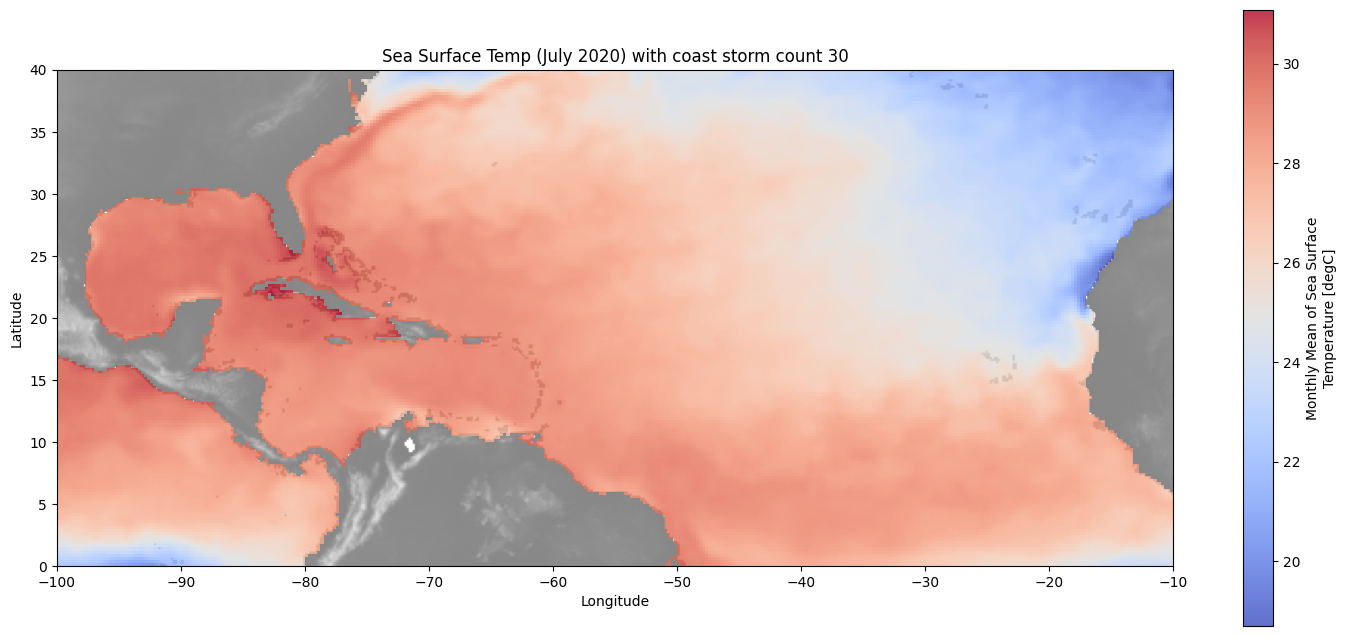

In [26]:
sst_sample = sst_ds['sst'].sel(time='2020-07-01')
sst_subset = sst_sample.sel(lat=slice(0,40), lon=slice(-100,-10))

# Plot both
fig, ax = plt.subplots(figsize=(18, 8))

#plot raster
show(raster, ax=ax, cmap='Greys_r', alpha=0.5)

# plot SST
sst_plot = sst_subset.plot(ax=ax, cmap='coolwarm', alpha=0.8, add_colorbar=True)

ax.set_title("Sea Surface Temp (July 2020) with coast storm count 30")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

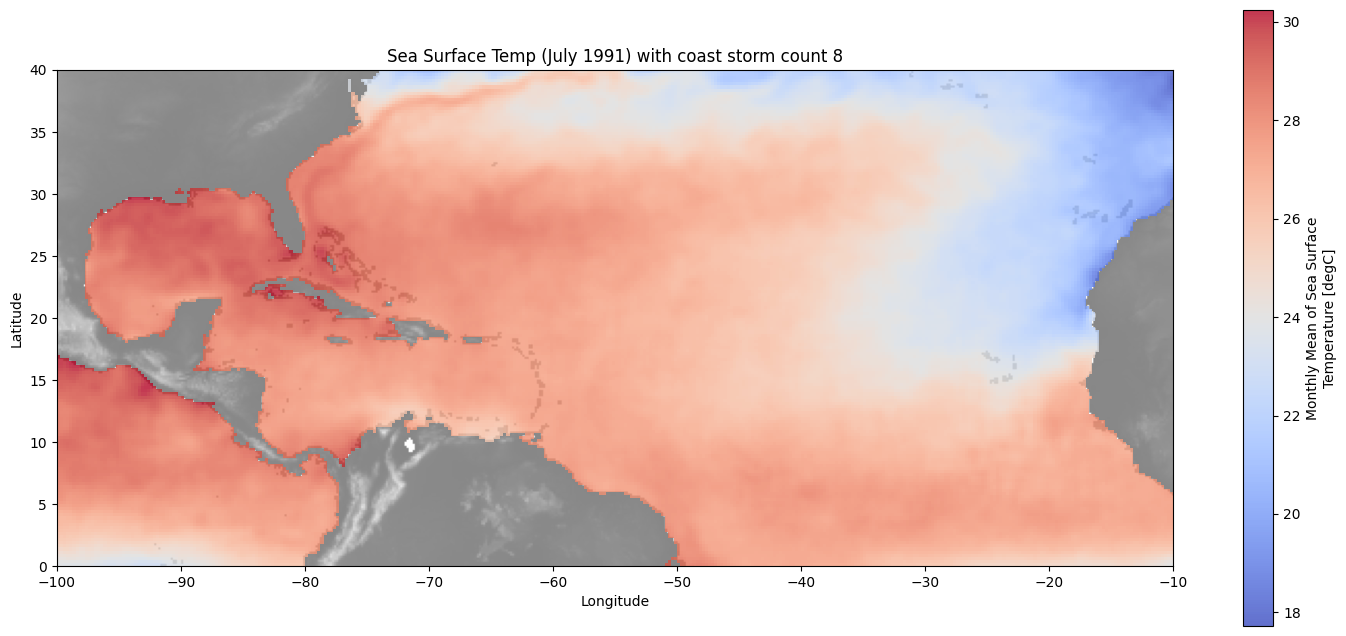

In [27]:
sst_sample = sst_ds['sst'].sel(time='1991-07-01')
sst_subset = sst_sample.sel(lat=slice(0,40), lon=slice(-100,-10))

# Plot both
fig, ax = plt.subplots(figsize=(18, 8))

#plot raster
show(raster, ax=ax, cmap='Greys_r', alpha=0.5)

# plot SST
sst_plot = sst_subset.plot(ax=ax, cmap='coolwarm', alpha=0.8, add_colorbar=True)

ax.set_title("Sea Surface Temp (July 1991) with coast storm count 8")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [28]:
sst_1990_onward = sst_refined.sel(time=slice("1990-01-01",None))


In [29]:
#Set the correct longitudinal data for mapping 
sst_1990_onward = sst_1990_onward.assign_coords(lon=(((sst_ds.lon + 180) % 360) - 180)).sortby('lon')

In [30]:
# Main Dev. Region (Atlantic)
sst_mdr = sst_1990_onward.sel(lat=slice(10, 20), lon=slice(-80, -20))

# Caribbean
sst_caribbean = sst_1990_onward.sel(lat=slice(10, 25), lon=slice(-95, -65))

# Gulf of Mexico/America
sst_gulf = sst_1990_onward.sel(lat=slice(18, 31), lon=slice(-100, -85))

## Sea Surface Temperature Anomalies

We will calculate the sea surface temperature anomalies, this is done by comparing sea surface temps to a long term- average at the same location at the same time of year. Its caluclated usually over 30 years or more. 

Baseline - Current SST (positive means water is warmer, negative colder)

In [31]:
print(sst_1990_onward.groupby("time.month").count("time"))

<xarray.Dataset> Size: 100MB
Dimensions:  (month: 12, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, lat, lon) int64 100MB 0 0 0 0 0 0 0 ... 35 35 35 35 35 35
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...


In [32]:
# Count the number of entries per month
month_counts = sst_1990_onward.groupby("time.month").count("time")['sst']

# Keep only months with full 36 monts of data if not it messes up the data for some reason
valid_months = month_counts.where(month_counts == 36, drop=True).month.values

# Filter time for those valid months
valid_times = sst_1990_onward.time[sst_1990_onward['time.month'].isin(valid_months)]

# Subset the data to those times
sst_filtered = sst_1990_onward.sel(time=valid_times)

# Now compute monthly climatology (1991–2020; 30 yr baseline )
climatology = sst_filtered.sel(time=slice("1991", "2020")).groupby("time.month").mean("time")

# Compute anomalies
sst_anomalies = sst_filtered.groupby("time.month") - climatology

print(sst_anomalies['sst'])

<xarray.DataArray 'sst' (time: 180, lat: 720, lon: 1440)> Size: 746MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.05621517,  0.05751634,  0.05804336, ...,  0.05818284,
          0.0579356 ,  0.05635512],
        [ 0.05588162,  0.05822587,  0.05898929, ...,  0.05945158,
          0.05917203,  0.05592477],
        [ 0.06158042,  0.06138682,  0.06121469, ...,  0.06056964,
          0.06092441,  0.06132221]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan

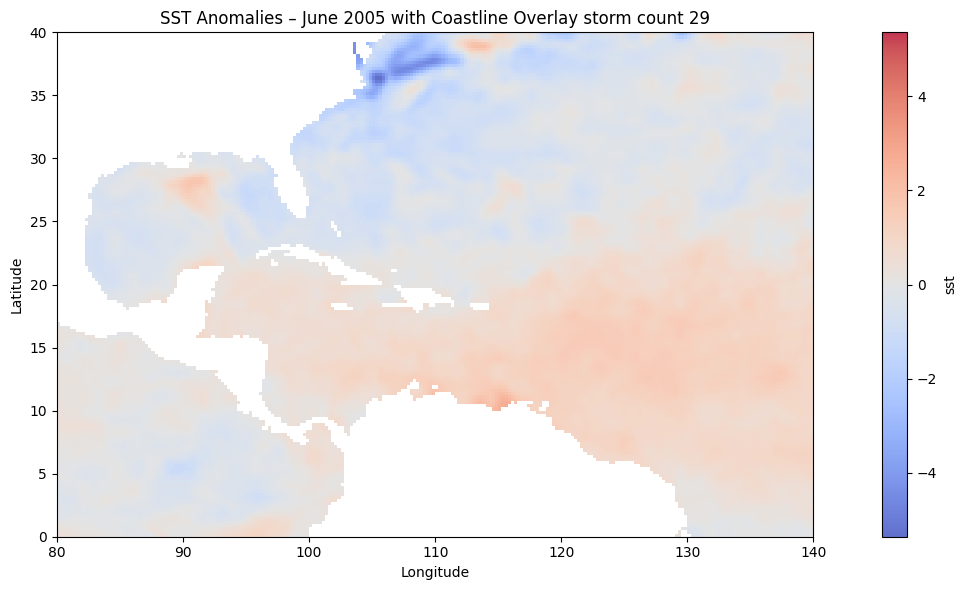

In [33]:
sst_subset_anom = sst_anomalies.sel(lat=slice(0,40), lon=slice(80,140))

elevation = rxr.open_rasterio(raster, masked=True).squeeze()
fig, ax = plt.subplots(figsize=(14, 6))

# Plot one SST anomaly
sst_subset_anom.sel(time='2005-06-01', method='nearest')['sst'].plot(ax=ax, cmap='coolwarm', alpha=0.8, add_colorbar=True)



# Overlay the elevation raster
show(elevation, ax=ax, cmap='Greys_r', alpha=0.4)  


ax.set_title("SST Anomalies – June 2005 with Coastline Overlay storm count 29")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


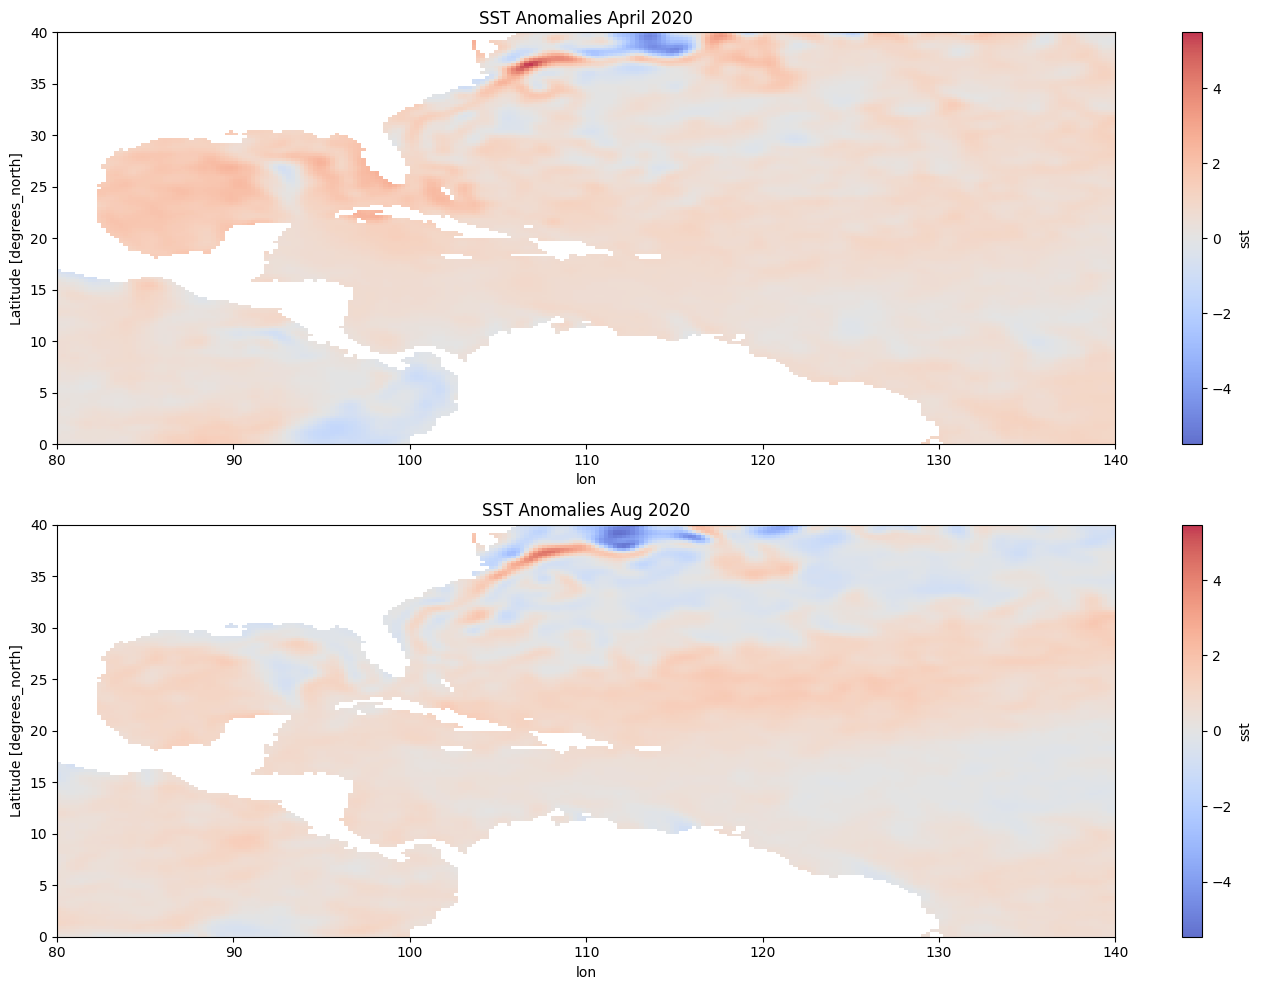

In [34]:
sst_subset_anom = sst_anomalies.sel(lat=slice(0,40), lon=slice(80,140))

elevation = rxr.open_rasterio(raster, masked=True).squeeze()
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,10))

# Plot one SST anomaly
sst_subset_anom.sel(time='2020-04-01', method='nearest')['sst'].plot(ax=ax1, cmap='coolwarm', alpha=0.8, add_colorbar=True)
sst_subset_anom.sel(time='2020-08-01', method='nearest')['sst'].plot(ax=ax2, cmap='coolwarm', alpha=0.8, add_colorbar=True)


# Overlay the elevation raster
show(elevation, ax=ax, cmap='Greys_r', alpha=0.4)  


ax1.set_title("SST Anomalies April 2020")
ax2.set_title("SST Anomalies Aug 2020")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

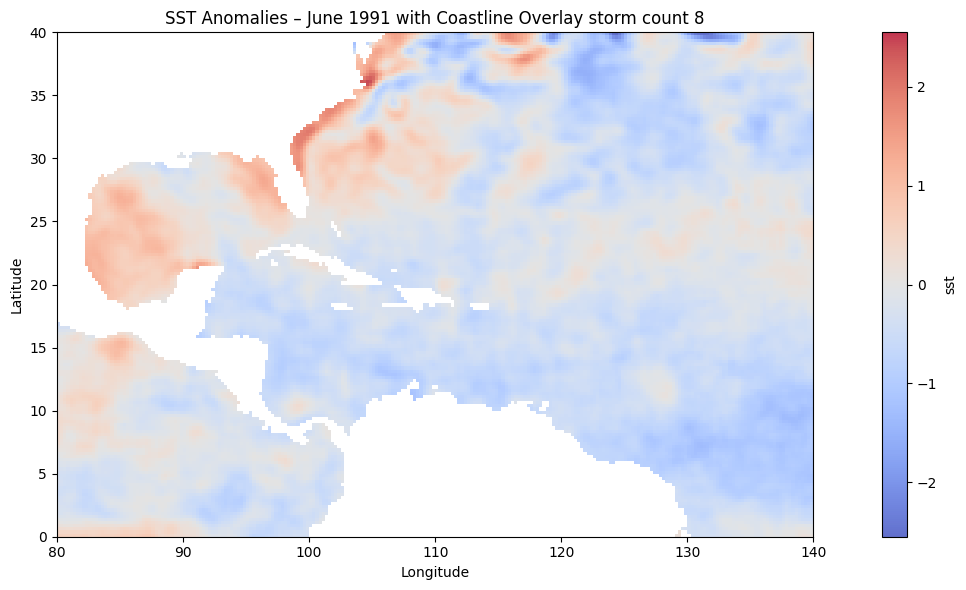

In [35]:
sst_subset_anom = sst_anomalies.sel(lat=slice(0,40), lon=slice(80,140))

elevation = rxr.open_rasterio(raster, masked=True).squeeze()
fig, ax = plt.subplots(figsize=(14, 6))

# Plot one SST anomaly
sst_subset_anom.sel(time='1991-06-01', method='nearest')['sst'].plot(ax=ax, cmap='coolwarm', alpha=0.8, add_colorbar=True)



# Overlay the elevation raster
show(elevation, ax=ax, cmap='gray', alpha=0.4)  


ax.set_title("SST Anomalies – June 1991 with Coastline Overlay storm count 8")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## Sun Spot Number

Next we will get the monthly mean Sun Spot Number. The data comes from the Royal Observatory of Belgium. 

Luckily they gave us some information on the column 

Filename: SN_m_tot_V2.0.csv
Format: Comma Separated values (adapted for import in spreadsheets)
The separator is the semicolon ';'.

Contents:
Column 1-2: Gregorian calendar date
- Year
- Month
Column 3: Date in fraction of year.
Column 4: Monthly mean total sunspot number.
Column 5: Monthly mean standard deviation of the input sunspot numbers.
Column 6: Number of observations used to compute the monthly mean total sunspot number.
Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.

In [36]:
sunspot = pd.read_csv("C:\\Users\\Kevin\\Downloads\\SN_m_tot_V2.0.csv", sep=';')

In [37]:
sunspot.head()

,1749,01,1749.042,96.7,-1.0,-1,1
0,1749,2,1749.123,104.3,-1.0,-1,1
1,1749,3,1749.204,116.7,-1.0,-1,1
2,1749,4,1749.288,92.8,-1.0,-1,1
3,1749,5,1749.371,141.7,-1.0,-1,1
4,1749,6,1749.455,139.2,-1.0,-1,1


In [38]:
#Sunspot data did not have any column headers, so we will make them. This is from the where we downloaded the data
sunspot.columns = [
    "Year", "Month", "Date_Fraction", 
    "Sunspot_Mean", "Std_Dev", "Observations", "Definitive"
]

In [39]:
sunspot['Date'] = pd.to_datetime(dict(year=sunspot['Year'], month=sunspot['Month'], day=1))

In [40]:
sunspot_filtered = sunspot[sunspot['Year'] >= 1990]

print(sunspot_filtered.head())

      Year  Month  Date_Fraction  Sunspot_Mean  Std_Dev  Observations  \
2891  1990      1       1990.042         227.4     13.6           516   
2892  1990      2       1990.123         171.8     11.3           518   
2893  1990      3       1990.204         191.7     11.0           592   
2894  1990      4       1990.288         189.7     10.1           575   
2895  1990      5       1990.371         175.2     10.0           691   

      Definitive       Date  
2891           1 1990-01-01  
2892           1 1990-02-01  
2893           1 1990-03-01  
2894           1 1990-04-01  
2895           1 1990-05-01  


# Quick EDA 

Lets see the observations by month to get a feel for the data.

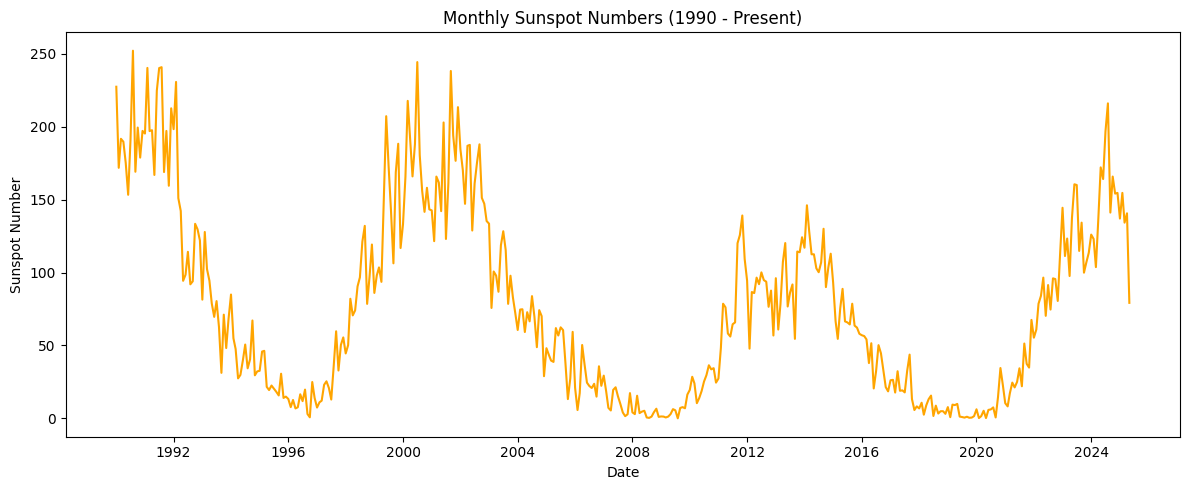

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(sunspot_filtered['Date'], sunspot_filtered['Sunspot_Mean'], color='orange')

plt.title("Monthly Sunspot Numbers (1990 - Present)")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")

 
plt.tight_layout()
plt.show()

In [42]:
storm_metrics['Date'] = pd.to_datetime(storm_metrics['year'].astype(str) + '-01-01')

## Dataset for Regression

Next we are going to manufacture a dataset from all of the data we have accumulated. We will need Hurricane count and ACE, then we will need SST for each region by year, then we will need the sunspot number by year as well.

First we will start with the Sea Surface temperatures for Apr to Jun we want the anomalies for that year

In [61]:
sst = xr.open_dataset('C:\\Users\\Kevin\\Downloads\\sst.mnmean.nc')

In [62]:
sst_1990_onward = sst.sel(time=slice("1990-01-01",None))

In [64]:
#Set the correct longitudinal data for mapping 
sst_1990_onward = sst_1990_onward.assign_coords(lon=(((sst_1990_onward.lon + 180) % 360) - 180)).sortby('lon')

In [65]:
# Main Dev. Region (Atlantic)
sst_mdr = sst_1990_onward.sel(lat=slice(10, 20), lon=slice(-80, -20))

# Caribbean
sst_caribbean = sst_1990_onward.sel(lat=slice(10, 25), lon=slice(-95, -65))

# Gulf of Mexico/America
sst_gulf = sst_1990_onward.sel(lat=slice(18, 31), lon=slice(-100, -85))

In [66]:
print(sst_1990_onward.groupby("time.month").count("time"))

<xarray.Dataset> Size: 2MB
Dimensions:    (month: 12, nbnds: 2, lat: 89, lon: 180)
Coordinates:
  * lat        (lat) float32 356B 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon        (lon) float32 720B -180.0 -178.0 -176.0 ... 174.0 176.0 178.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (month, nbnds) int64 192B 36 36 36 36 36 36 ... 35 35 35 35 35 35
    sst        (month, lat, lon) int64 2MB 36 36 36 36 36 36 36 ... 0 0 0 0 0 0
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermomet

In [67]:
# Count the number of entries per month
month_counts = sst_1990_onward.groupby("time.month").count("time")['sst']

# Keep only months with full 36 monts of data if not it messes up the data for some reason
valid_months = month_counts.where(month_counts == 36, drop=True).month.values

# Filter time for those valid months
valid_times = sst_1990_onward.time[sst_1990_onward['time.month'].isin(valid_months)]

# Subset the data to those times
sst_filtered = sst_1990_onward.sel(time=valid_times)

# Now compute monthly climatology (1991–2020; 30 yr baseline )
climatology = sst_filtered.sel(time=slice("1991", "2020")).groupby("time.month").mean("time")

# Compute anomalies
sst_anomalies = sst_filtered.groupby("time.month") - climatology

In [68]:
sst_anomalies.head()

<xarray.Dataset> Size: 700B
Dimensions:    (lat: 5, time: 5, lon: 5, nbnds: 2)
Coordinates:
  * lat        (lat) float32 20B 88.0 86.0 84.0 82.0 80.0
  * time       (time) datetime64[ns] 40B 1990-01-01 1990-02-01 ... 1990-05-01
  * lon        (lon) float32 20B -180.0 -178.0 -176.0 -174.0 -172.0
    month      (time) int64 40B 1 2 3 4 5
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 80B 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float32 500B -4.768e-07 ... -4.768e-07

In [70]:
#Keep only months of apr-jun
spring = sst_anomalies.sel(time=sst_anomalies.time.dt.month.isin([4, 5, 6]))

#had chatgpt help with building this helper function to get the correct syntax for building the syntax for this helpper function
# My problem I had before was the table was being built with NaNs being set through the whole table
#Helper to build (Year, mean_SST) for any region
def yearly_mean(da, lat_hi, lat_lo, lon_w, lon_e, col):
    sub = da['sst'].sel(lat=slice(lat_hi, lat_lo), lon=slice(lon_w, lon_e))
    space_mean = sub.mean(dim=['lat', 'lon'], skipna=True)
    # turn DataArray into a dataframe with column name
    df = (space_mean.to_dataframe(name=col).reset_index())
    df = (df.groupby(df['time'].dt.year)[col].mean().reset_index().rename(columns={'time': 'Year'})) 
    return df


#Regions
carib = yearly_mean(spring, 25, 10, -90, -60, 'Caribbean_sst')
gulf  = yearly_mean(spring, 31, 18, -98, -80, 'Gulf_sst')
mdr   = yearly_mean(spring, 20, 10, -60, -20, 'MDR_sst')

#merge into one table
sst_features = carib.merge(gulf, on='Year')
sst_features = sst_features.merge(mdr, on='Year')
print(sst_features.head(16))



    Year  Caribbean_sst  Gulf_sst   MDR_sst
0   1990      -0.259537 -0.028508  0.115612
1   1991      -0.244492  0.462579 -0.501981
2   1992      -0.379970 -0.736078 -0.376198
3   1993      -0.281088 -1.023366 -0.206674
4   1994      -0.087203  0.232070 -0.761361
5   1995       0.100915  0.287410  0.128568
6   1996      -0.376211 -0.697751  0.142145
7   1997      -0.226576 -0.316722  0.149428
8   1998       0.090898 -0.573168  0.339453
9   1999      -0.012746  0.069944 -0.353274
10  2000      -0.433825  0.139071 -0.390075
11  2001      -0.380191 -0.333166 -0.249226
12  2002      -0.117382  0.603183 -0.201057
13  2003       0.200306  0.268297 -0.305860
14  2004      -0.179448 -0.337594  0.107883
15  2005       0.267711 -0.164367  0.932375


Next we will get the sunspots by year and get the average for the 3 months of Apr-June

In [71]:
sunspot_filtered['Year'] = sunspot_filtered['Year'].astype(int)

# Filter for Apr-Jun
early_season_sunspots = sunspot_filtered[sunspot_filtered['Month'].between(4, 6)]

# average out the gropu
sunspot_apr_jun_avg = early_season_sunspots.groupby('Year')['Sunspot_Mean'].mean().reset_index()
sunspot_apr_jun_avg.columns = ['Year', 'Sunspot_AprJun']

C:\Users\Kevin\AppData\Local\Temp\ipykernel_38032\2805595165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunspot_filtered['Year'] = sunspot_filtered['Year'].astype(int)


In [72]:
sunspot_apr_jun_avg['year'] = sunspot_apr_jun_avg['Year']

In [73]:
regr_data = storm_metrics.merge(sunspot_apr_jun_avg, on='year')


In [74]:
regr_data = regr_data.merge(sst_features, on='Year')


In [75]:
regr_data.head()

,year,storm_count,ACE,Date,Year,Sunspot_AprJun,Caribbean_sst,Gulf_sst,MDR_sst
0,1990,14,196.3938,1990-01-01,1990,172.733333,-0.259537,-0.028508,0.115612
1,1991,8,85.1744,1991-01-01,1991,196.400000,-0.244492,0.462579,-0.501981
2,1992,7,166.7311,1992-01-01,1992,111.666667,-0.379970,-0.736078,-0.376198
3,1993,9,86.4490,1993-01-01,1993,80.933333,-0.281088,-1.023366,-0.206674
4,1994,7,63.7578,1994-01-01,1994,32.300000,-0.087203,0.232070,-0.761361


In [76]:
regr_data.tail()

,year,storm_count,ACE,Date,Year,Sunspot_AprJun,Caribbean_sst,Gulf_sst,MDR_sst
30,2020,30,402.1780,2020-01-01,2020,3.733333,0.646840,0.894673,0.339361
31,2021,21,337.5270,2021-01-01,2021,23.566667,0.157576,0.113266,0.036217
32,2022,14,272.6475,2022-01-01,2022,83.600000,0.160007,0.418756,-0.004723
33,2023,20,348.6041,2023-01-01,2023,131.833333,0.512302,0.892026,0.792550
34,2024,19,371.2912,2024-01-01,2024,157.733333,1.040275,0.801171,1.362332


In [83]:
X = regr_data[['Caribbean_sst','Gulf_sst','MDR_sst','Sunspot_AprJun']]
y = regr_data['ACE']                       

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

model = LinearRegression().fit(X_train, y_train)

print("Test R2 :", r2_score(y_test, model.predict(X_test)))
print("Coeffs  :", dict(zip(X.columns, model.coef_)))
print("Intercept:", model.intercept_)


Test R2 : 0.05804001102859879
Coeffs  : {'Caribbean_sst': np.float64(-134.15091496306914), 'Gulf_sst': np.float64(121.06622709273445), 'MDR_sst': np.float64(146.85903703782742), 'Sunspot_AprJun': np.float64(-0.6359019338747913)}
Intercept: 304.65264253748126


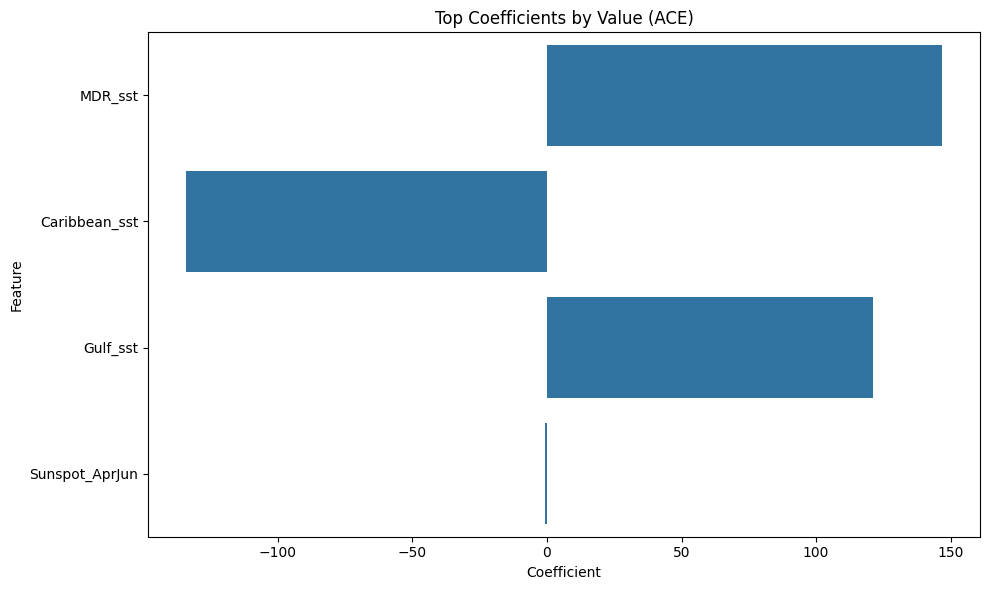

In [84]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(8), x='Coefficient', y='Feature')
plt.title("Top Coefficients by Value (ACE)")
plt.tight_layout()
plt.show()

In [79]:
X = regr_data[['Caribbean_sst','Gulf_sst','MDR_sst','Sunspot_AprJun']]
y = regr_data['storm_count']                       

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

model = LinearRegression().fit(X_train, y_train)
print("Test R2 :", r2_score(y_test, model.predict(X_test)))
print("Coeffs  :", dict(zip(X.columns, model.coef_)))
print("Intercept:", model.intercept_)

Test R2 : 0.4911043242102421
Coeffs  : {'Caribbean_sst': np.float64(-0.6116690909486376), 'Gulf_sst': np.float64(4.350120274592936), 'MDR_sst': np.float64(5.013822989679016), 'Sunspot_AprJun': np.float64(-0.01892834261777221)}
Intercept: 15.606269676019359


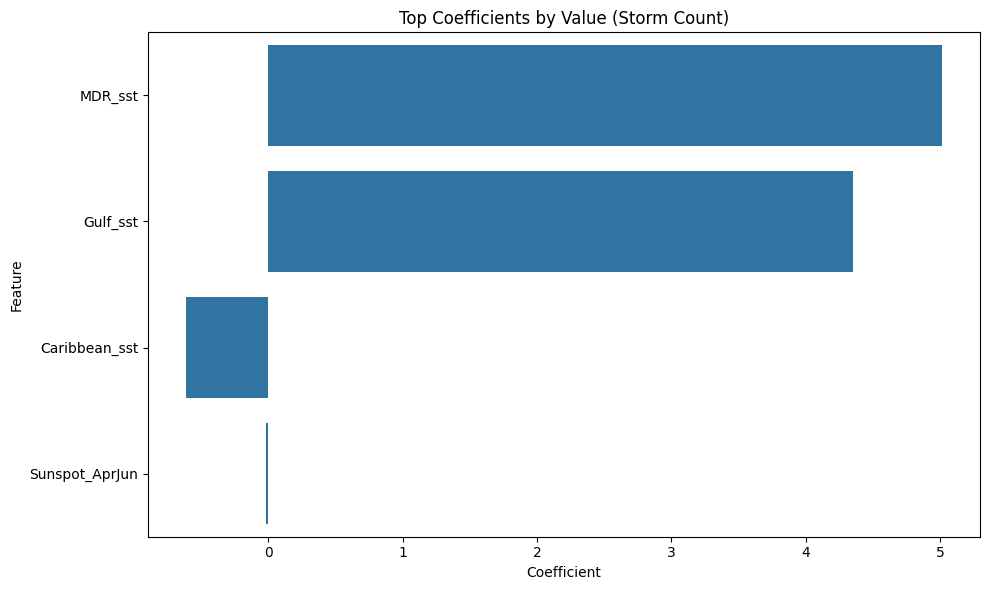

In [82]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(8), x='Coefficient', y='Feature')
plt.title("Top Coefficients by Value (Storm Count)")
plt.tight_layout()
plt.show()